**Used cars dataset**

Giant online marketplaces like E-Bay are leveraging the growth rate of used car industy
The following report, explores Kaggle’s ‘Used Car Database’ scraped from Ebay-Kleinanzeigen (in German). 
Containing prices and attributes for approximately 370.000 second-hand cars of 40 unique brands. 
The sample contains ads that created between March 2015 and April 2016. 

It is a very messy dataset. Perfect to pratice data cleaning.
The dataset is also accompanied by another file containg a MySQL query:

    select 
     count(*) as count, 
     kilometer, 
     yearOfRegistration, 
    20*round(powerPS/20) as powerPS, 
    min(price) as minprice, 
    max(price) as maxPrice, 
    avg(price) as avgPreis, 
    sqrt(variance(price)) as sdPreis from items where 
         yearOfRegistration > 1990 and yearOfRegistration < 2016 
        and price > 100 and price < 100000 
        and powerPS < 600 and powerPS > 0 
     group by yearOfRegistration, round(powerPS/20),kilometer 
    having count > 10 
    into outfile '/tmp/cnt_km_year_powerPS_minPrice_maxPrice_avgPrice_sdPrice.csv' 
    fields terminated by ',' lines terminated by '\n';

It is an useful dataset,to pratice data cleaning, dealing with mixed data (str. and int. in the same column) 
and run some ad-hoc analysis (clustering cars, regression analysis on price,etc). Also some issues with german characters.

Disclaimer This is not a colurful presentation, I have other notebook for that. 
it is only to demonstrate though process, and achieve a clean, workable dataset.

In the second notebook, an analysis will be made, aimed at the price prediction and clustering specifics

Index:
    1.  Importing necessary packages and data
    2.  General analysis (overview of the dataset)
    3.1 Pre-processing
    3.2 Pre-processing (specific analysis)
    4.  Missing Values
    5.  Analysis of target variable 
    6.  Output file

**1 Importing necessary packages and data**

In [1]:
import numpy as np 
import pandas as pd
import re
import requests
from nltk.tokenize import RegexpTokenizer
from sklearn import preprocessing
import matplotlib 
matplotlib.use('agg')
## agg backend is used to create plot as a .png file
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
autos = pd.read_csv('C:\\Users\\Marci\\Desktop\\datasets\\autos.csv',encoding = 'cp1252') #import data
autos_original = autos #for later comparison

**2 General analysis (overview of the dataset)**

In [3]:
autos.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
print(autos.info())
print('#'*40)
print('Nr. of observations,nr. of columns')
print(autos.shape) 
print('#'*40)
# Continuous Variables
print('Continuous variables')
print(autos.describe()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
dateCrawled            371528 non-null object
name                   371528 non-null object
seller                 371528 non-null object
offerType              371528 non-null object
price                  371528 non-null int64
abtest                 371528 non-null object
vehicleType            333659 non-null object
yearOfRegistration     371528 non-null int64
gearbox                351319 non-null object
powerPS                371528 non-null int64
model                  351044 non-null object
kilometer              371528 non-null int64
monthOfRegistration    371528 non-null int64
fuelType               338142 non-null object
brand                  371528 non-null object
notRepairedDamage      299468 non-null object
dateCreated            371528 non-null object
nrOfPictures           371528 non-null int64
postalCode             371528 non-null int64
lastSeen              

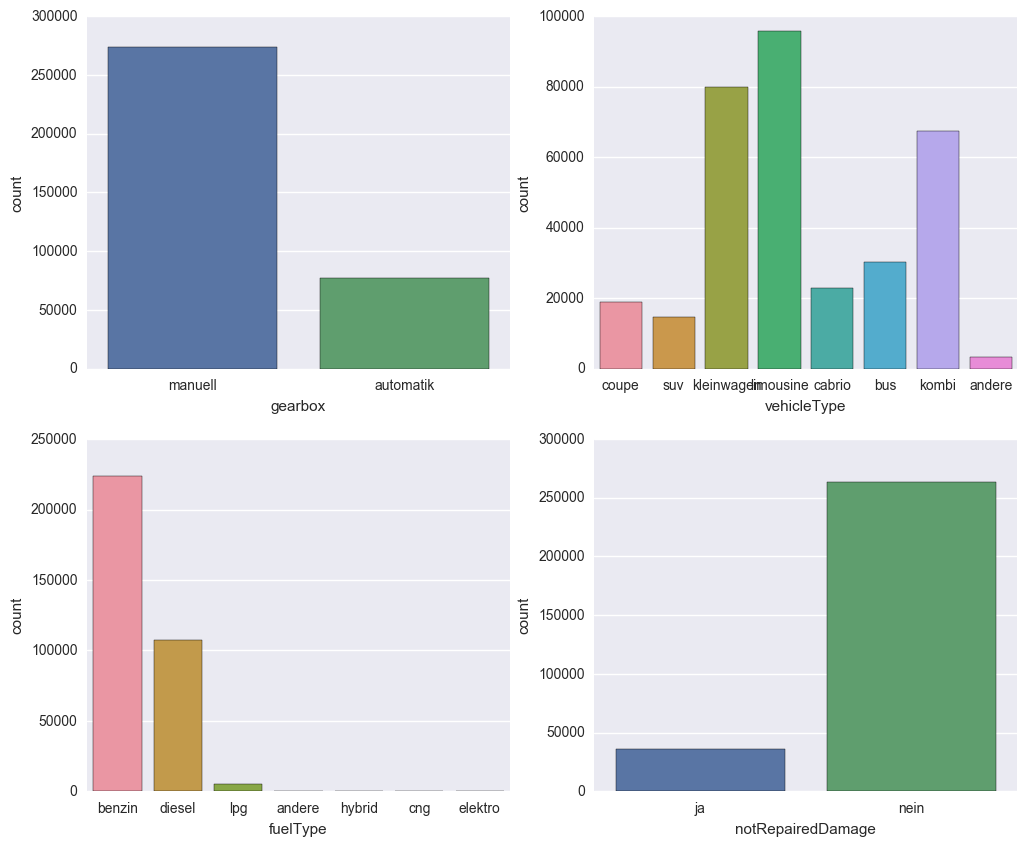

In [5]:
# Categorical Values
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
sns.countplot(autos['gearbox'])
plt.subplot(2,2,2)
sns.countplot(autos['vehicleType'])
plt.subplot(2,2,3)
sns.countplot(autos['fuelType'])
plt.subplot(2,2,4)
sns.countplot(autos['notRepairedDamage'])
plt.show()

Conclusions so far:
- The dataset has a total of:
371528 observations and 20 columns.
- Some columns have no additional information, or, are irrelevant (e.g.: pictures column).
- Obvious outliers (e.g.: PowerPS and Price)
- Some obvious moves in the categorical values

**3.1 Pre-processing**

In [6]:
#Dropping columns with irrelevant information
autos = autos.drop('nrOfPictures',axis=1) 
autos = autos.drop('dateCrawled',axis=1) 
autos = autos.drop('lastSeen',axis=1)

#Postal is categorical information
autos['postalCode'] = autos['postalCode'].astype(str)

#In some continuous variables,such as price, it is safe to assume that zero is a 'missing value'
autos['price'].replace(0,np.NaN,inplace=True) 
autos['monthOfRegistration'].replace(0,np.NaN,inplace=True) 
autos['powerPS'].replace(0,np.NaN,inplace=True) 

#Cleaning obvious outliers
# autos['yearOfRegistration'].astype(int)
autos = autos[(autos.yearOfRegistration >=1901) & (autos.yearOfRegistration <=2016)]
autos.powerPS.astype('float') 
autos[autos.powerPS > 1000.0] = np.NaN    #invalid field assumed as 'empty'
autos[autos.powerPS == 0] = np.NaN      
autos[autos.price == 0] = np.NaN       

# Removing the duplicates
autos = autos.drop_duplicates(['name','price','vehicleType','yearOfRegistration'
                         ,'gearbox','powerPS','model','kilometer','monthOfRegistration','fuelType'
                         ,'notRepairedDamage'])

#separate dates and time
autos['date_Created'], autos['time_created'] = autos['dateCreated'].str.split(' ', 1).str   
autos = autos.drop('dateCreated',axis=1)

**3.2 Pre-processing (specific analysis)**

In [7]:
# Analysis of 'name' column
autos.name.head(20)

0                                            Golf_3_1.6
1                                  A5_Sportback_2.7_Tdi
2                        Jeep_Grand_Cherokee_"Overland"
3                                    GOLF_4_1_4__3TÜRER
4                        Skoda_Fabia_1.4_TDI_PD_Classic
5     BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...
6                           Peugeot_206_CC_110_Platinum
7                          VW_Derby_Bj_80__Scheunenfund
8                  Ford_C___Max_Titanium_1_0_L_EcoBoost
9     VW_Golf_4_5_tuerig_zu_verkaufen_mit_Anhaengerk...
10                                    Mazda_3_1.6_Sport
11        Volkswagen_Passat_Variant_2.0_TDI_Comfortline
12                    VW_Passat_Facelift_35i__"7Sitzer"
13                       VW_PASSAT_1.9_TDI_131_PS_LEDER
14    Nissan_Navara_2.5DPF_SE4x4_Klima_Sitzheizg_Blu...
15                         KA_Lufthansa_Edition_450€_VB
16                                          Polo_6n_1_4
17                          Renault_Twingo_1.2_1

From above, we see lots of special caracheters and expressions , that should be removed. E.g: !!!, '_', caps lock descriptions,...
The fields 'name' and 'model' should be normalized (using NLTK principles). 
The idea, is to retrieve the 'model' from the 'name' discrition, in case of missing value or, conflicting data.

In [8]:
#"_" is often used as a space therefore will be treated seperately
autos['name'] = autos['name'].astype(str) #str to avoid conflict with german characters
autos['name'] = autos['name'].str.replace("_",' ')
tokenizer = RegexpTokenizer(r'\w+')
for item in autos['name']:
    tokenizer.tokenize(item)  

#tokenize(), misses certain cases (source: http://www.nltk.org/book/ch03.html)   
#regex for remaining cases with the special characters/cases
autos['name'] = autos['name'].str.replace('.','')
autos['name'] = autos['name'].str.replace('  ',' ')
autos['name'] = autos['name'].str.replace('"','')
autos['name'] = [w.lower() for w in autos['name']] 
print(autos.name.head(20)) #much cleaner

0                                             golf 3 16
1                                   a5 sportback 27 tdi
2                          jeep grand cherokee overland
3                                     golf 4 1 4 3türer
4                         skoda fabia 14 tdi pd classic
5       bmw 316i  e36 limousine  bastlerfahrzeug export
6                           peugeot 206 cc 110 platinum
7                           vw derby bj 80 scheunenfund
8                   ford c  max titanium 1 0 l ecoboost
9     vw golf 4 5 tuerig zu verkaufen mit anhaengerk...
10                                     mazda 3 16 sport
11         volkswagen passat variant 20 tdi comfortline
12                       vw passat facelift 35i 7sitzer
13                        vw passat 19 tdi 131 ps leder
14    nissan navara 25dpf se4x4 klima sitzheizg blue...
15                         ka lufthansa edition 450€ vb
16                                          polo 6n 1 4
17                            renault twingo 12 

In [9]:
# Analysis of 'model' column
len(set(autos.model.unique())) #there was 'nan' model that is actually NaN
print(autos[autos.model == 'nan'].std()['price']) #this proves the theory above
autos[autos.model == 'nan'] = np.NaN

# Normalizing 'model' column
autos['model'] = autos['model'].str.replace("_",' ')
tokenizer = RegexpTokenizer(r'\w+')
for item in autos['model']: 
    tokenizer.tokenize(str(item))
#cleaning the remaining cases    
autos['model'] = autos['model'].str.replace('.','')
autos['model'] = autos['model'].str.replace('  ',' ')
autos['name'] = autos['name'].str.replace('"','')
autos.model.str.lower()

nan


0                golf
1                 NaN
2               grand
3                golf
4               fabia
5                 3er
6             2 reihe
7              andere
8               c max
9                golf
10            3 reihe
11             passat
12             passat
13             passat
14             navara
15                 ka
16               polo
17             twingo
18              c max
19           a klasse
20           scirocco
21                5er
23              arosa
24             andere
25                5er
27              civic
28        transporter
29              punto
30           e klasse
31               clio
             ...     
371497          astra
371498         vectra
371499          corsa
371500           golf
371501        voyager
371502             a4
371503          justy
371504       c klasse
371505          astra
371506           golf
371507             a4
371508          astra
371509            NaN
371510       e klasse
371511    

In the cases below both the column 'seller' and 'offerType' are deleted.
Due to little to none, additional infomartion. 
Hence these should be treated as outliers, and defeat the purpose of anlaysis

In [10]:
print(autos.groupby('seller').size())
autos = autos.drop('seller', 1) #remove the 'seller' (only 3 'gewerblich' in the whole dataset)
print(10*'#')
print(autos.groupby('offerType').size())
autos = autos.drop('offerType', 1) #remove the 'offerType' instances (only 12 cases 'Gesuch')

seller
gewerblich         3
privat        347938
dtype: int64
##########
offerType
Angebot    347929
Gesuch         12
dtype: int64


**4. Missing Values**

In [11]:
autos.isnull().sum()

name                       0
price                   9652
abtest                     1
vehicleType            22833
yearOfRegistration         1
gearbox                17172
powerPS                35605
model                  18141
kilometer                  1
monthOfRegistration    33209
fuelType               27339
brand                      1
notRepairedDamage      63797
postalCode                 1
date_Created               1
time_created               1
dtype: int64

When imputing missing values, one could search for patterns or rules of thumb to fill NAs.

In dataset a combination of same models and brand, should give the same mean PowerPS (HorsePower).
Same model should have the same mean PowerPS (needs further testing).
Electric cars have electric gears and vice versa.
Same model and brand have the same vehicleType.

In [12]:
#Missing values: 'model'
temporary = autos.model.astype('str')
models_list = temporary.unique().tolist()
models =  re.compile(r'\b(?:%s)\b' % '|'.join(models_list))
for i,row in autos.loc[autos['model'].isnull(),:].iterrows():
    if  re.search(models,autos.loc[i,'name']) != None:
        autos.loc[i,'model'] = re.search(models,autos.loc[i,'name']).group()  
print('more than 10000 NAs solved:',autos.model.isnull().sum(),)
autos['model'].replace(np.NaN,'non-declared',inplace=True)  # fill remaining NAs
        
# Missing Values: 'powerPS'
print(autos.groupby(['yearOfRegistration','model']).std()['powerPS'].mean()) #the diviation is small, imputation can be applied
autos['powerPS'] = autos.groupby(['yearOfRegistration','brand','model']).transform(lambda x: x.fillna(x.mean()))['powerPS']

# Missing values: 'notRepairedDamage'
#two possible approaches: fill.na using the mode, or, fill in with 'non-declared' 
#(the last one is standard pratice in e-commerce, as it afects the value of the sale)
print(autos.groupby('notRepairedDamage').size())
autos['notRepairedDamage'].replace(np.NaN,'non-declared',inplace=True)  

#Missing Values: 'gearbox' & 'fuelType'
autos[(autos.gearbox =='automatik')]['fuelType'] = 'elektro'  
autos[(autos.fuelType =='elektro')]['gearbox'] = 'automatik'
autos['fuelType'].fillna(autos['fuelType'].mode(), inplace=True)
autos['gearbox'].fillna(autos['gearbox'].mode(), inplace=True)

# Missing Values: 'vehicleType'
# autos['vehicleType'] = autos.groupby(['brand','model']).transform(lambda x: x.fillna(x.mode().iloc[0]))['vehicleType']     

#inspirations: https://www.analyticsvidhya.com/blog/2016/01/12-pandas-techniques-python-data-manipulation/
#http://stackoverflow.com/questions/3040716/python-elegant-way-to-check-if-at-least-one-regex-in-list-matches-a-string
#http://stackoverflow.com/questions/17679089/pandas-dataframe-groupby-two-columns-and-get-counts
#Food for thought:Knn imputation might be an alternative solution

more than 10000 NAs solved: 9787
26.680814718633453
notRepairedDamage
ja       34605
nein    249540
dtype: int64


C:\Users\Marci\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Marci\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
# Improvment
print('Improvment:',autos.isnull().sum())

Improvment: name                       0
price                   9652
abtest                     1
vehicleType            22833
yearOfRegistration         1
gearbox                17172
powerPS                  852
model                      0
kilometer                  1
monthOfRegistration    33209
fuelType               27339
brand                      1
notRepairedDamage          0
postalCode                 1
date_Created               1
time_created               1
dtype: int64


**5. Target variable analysis**

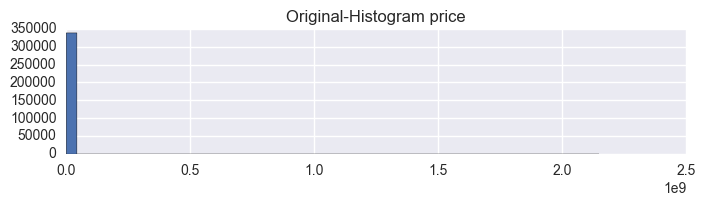

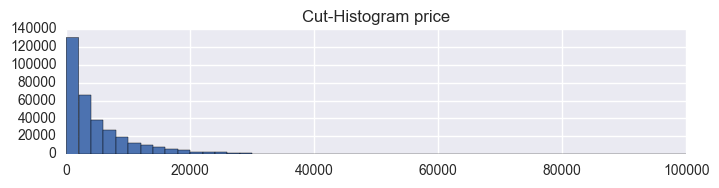

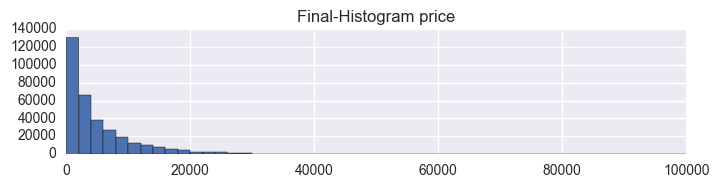

In [14]:
# Inspecting: price
plt.subplot(3,1,1)
autos['price'].hist(bins=50)
plt.title('Original-Histogram price')
plt.show()
#There are kinda expensive cars on sale. The owners are slightly overestimating the value I guess.

#I'll' cut the price at 100000
work_data = autos[autos.price < 100000]
expensive_autos = autos[autos.price >= 100000]

plt.subplot(3,1,2)
work_data['price'].hist(bins=50)
plt.title('Cut-Histogram price')
plt.show()


work_data = autos[autos.price < 100000]  
autos = work_data

plt.subplot(3,1,3)
work_data['price'].hist(bins=50)
plt.title('Final-Histogram price')
plt.show()

C:\Users\Marci\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


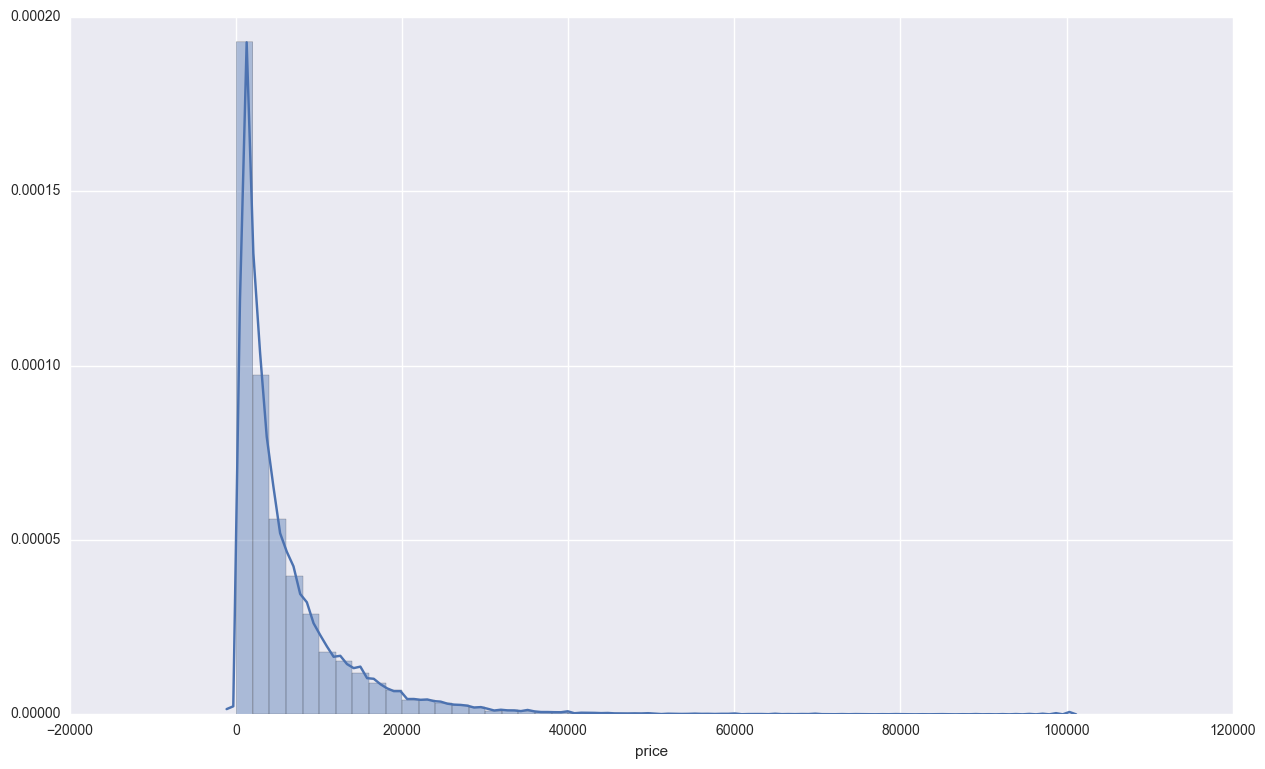

skewness of price distribution: 3.47589615925


In [15]:
# Distribution of price
plt.subplots(figsize=(15,9))
sns.distplot(autos['price'])
sns.plt.show()
print('skewness of price distribution:',autos['price'].skew()) #the distribution is skewed to the left

In [16]:
# Preparation of categorical features for analysis
labels = ['gearbox', 'notRepairedDamage', 'model', 'brand', 'fuelType', 'vehicleType','postalCode']
les = {}

for l in labels:
    les[l] = preprocessing.LabelEncoder()
    les[l].fit(autos[l].astype(str))
    tr = les[l].transform(autos[l].astype(str)) 
    autos.loc[:, l + '_feat'] = pd.Series(tr, index=autos.index)

autos_oneHot = autos[ ['price'
                        ,'yearOfRegistration'
                        ,'powerPS'
                        ,'kilometer'
                        ,'monthOfRegistration'] 
                    + [x+"_feat" for x in labels]]

314762    99999.0
197716    99999.0
217647    99999.0
172644    99999.0
370236    99999.0
342112    99999.0
22451     99999.0
141883    99999.0
18247     99999.0
342755    99999.0
147998    99999.0
111649    99990.0
317319    99990.0
128457    99911.0
14641     99900.0
183239    99900.0
329265    99900.0
206560    99900.0
326221    99900.0
64924     99900.0
62097     99500.0
283074    99500.0
203073    99000.0
113575    99000.0
132263    99000.0
68031     99000.0
147788    99000.0
64338     99000.0
216148    99000.0
276866    99000.0
           ...   
76993         1.0
1011          1.0
85330         1.0
59972         1.0
334899        1.0
241291        1.0
202329        1.0
241306        1.0
170094        1.0
94345         1.0
350140        1.0
77020         1.0
94287         1.0
24729         1.0
29796         1.0
218647        1.0
230640        1.0
129160        1.0
230637        1.0
117765        1.0
263511        1.0
263482        1.0
252429        1.0
218746        1.0
252444    

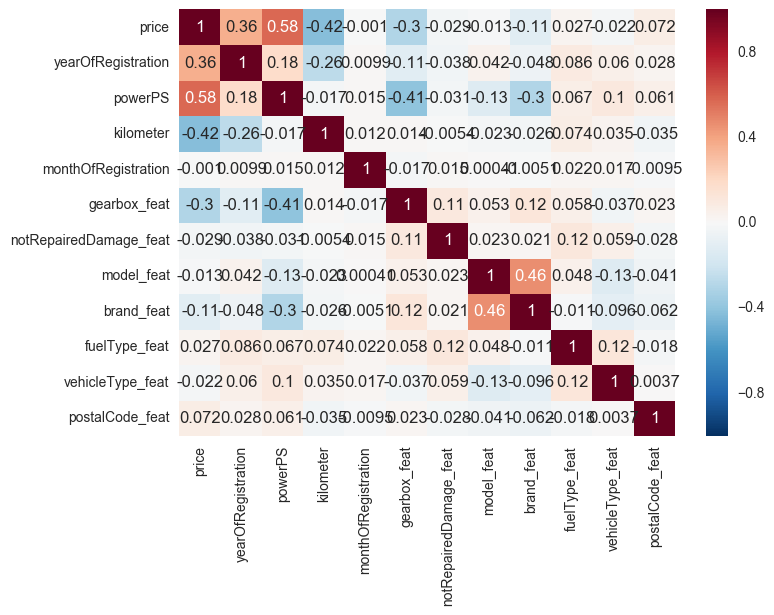

In [17]:
# Correlations with target variable
sns.heatmap(autos_oneHot.corr(), annot=True)
autos_oneHot.loc[:,'price'].abs().sort_values(ascending=False)[1:]

**Conclusions**
    - Model imputation proved to be a big winner: over 10000 NAs soilved by comparing with the name feature
    - Brand is the big component of price, followed by yearOFregistration and brand
    - Data cleaning is a never ending job. The beauty of working with very poor datasets, 
      is no matter how far you have gone, it is always possible to improve.




In [18]:
#saving output file
autos_oneHot.to_csv('C:\\Users\\Marci\\Desktop\\datasets\\autos_output.csv', index=False)